In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/LTU (1)/ADL_share/Project/data'

import torchvision.transforms as transforms

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=path+'/train', transform=transforms_train)
val_dataset = ImageFolder(root=path+'/val', transform=transforms_val)
test_dataset = ImageFolder(root=path+'/test', transform=transforms_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [5]:
num_classes = 2
batch_size = 8

feature_extract = False

activation = nn.LeakyReLU(0.1)
dropout = nn.Dropout(0.5)

model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs,2)

input_size = 224

print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 77.2MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [7]:
criterion = nn.CrossEntropyLoss()
num_epochs = 30

model_ft, hist = train_model(model_ft,
                             dataloaders,
                             criterion,
                             optimizer_ft,
                             num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 0.3288 Acc: 0.8606
val Loss: 0.2969 Acc: 0.8935

Epoch 1/29
----------
train Loss: 0.2536 Acc: 0.8933
val Loss: 0.1648 Acc: 0.9259

Epoch 2/29
----------
train Loss: 0.2285 Acc: 0.9105
val Loss: 0.2322 Acc: 0.9398

Epoch 3/29
----------
train Loss: 0.2120 Acc: 0.9143
val Loss: 0.1704 Acc: 0.9398

Epoch 4/29
----------
train Loss: 0.1964 Acc: 0.9195
val Loss: 0.1684 Acc: 0.9352

Epoch 5/29
----------
train Loss: 0.1831 Acc: 0.9308
val Loss: 0.1807 Acc: 0.9213

Epoch 6/29
----------
train Loss: 0.1777 Acc: 0.9288
val Loss: 0.2455 Acc: 0.9259

Epoch 7/29
----------
train Loss: 0.1788 Acc: 0.9348
val Loss: 0.1878 Acc: 0.9398

Epoch 8/29
----------
train Loss: 0.1796 Acc: 0.9318
val Loss: 0.1793 Acc: 0.9213

Epoch 9/29
----------
train Loss: 0.1647 Acc: 0.9362
val Loss: 0.1687 Acc: 0.9398

Epoch 10/29
----------
train Loss: 0.1612 Acc: 0.9398
val Loss: 0.1769 Acc: 0.9491

Epoch 11/29
----------
train Loss: 0.1518 Acc: 0.9430
val Loss: 0.1474 Acc: 0.9491

Ep

In [8]:
torch.save(model_ft.state_dict(), './alexnet_finetuned2.pth')

In [10]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features


model_ft.classifier[6] = nn.Linear(num_ftrs,2)
input_size = 224

model_ft.load_state_dict(torch.load('./alexnet_finetuned2.pth')) 

<All keys matched successfully>

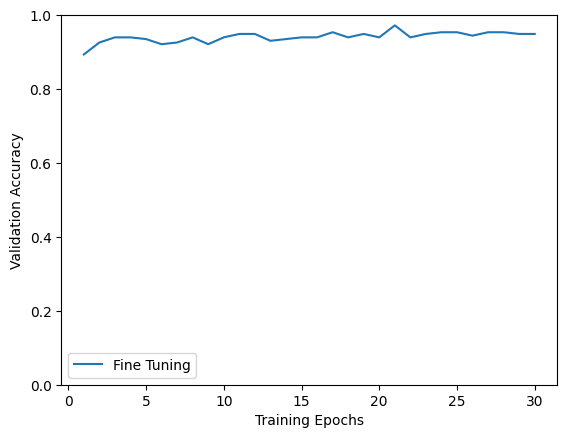

In [12]:
fhist = []

fhist = [h.cpu().numpy() for h in hist]

plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),fhist,label="Fine Tuning")
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs+1, 5.0))
plt.legend()
plt.show()

In [11]:
correct, total = 0, 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100 * correct // total} %')

Accuracy on test set: 94 %


In [13]:
correct, total = 0, 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100 * correct / total} %')

Accuracy on test set: 94.87179487179488 %
